# K-profiles in KPP

In this notebook we explore K-profiles in the K-profile parameterization.

In [41]:
using Pkg; Pkg.activate(".."); Pkg.instantiate()

using OceanTurb, PyPlot, PyPlotPlus, Printf

import PyPlot: plot

plot(f::Field, args...; kwargs...) = plot(data(f), nodes(f), args...; kwargs...)
plot(op::Function, f::Field, args...; kwargs...) = plot(op.(data(f)), nodes(f), args...; kwargs...)

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


plot (generic function with 3 methods)

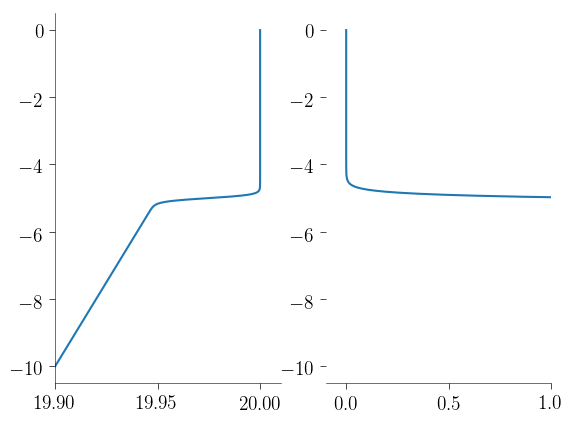

initial mixing depth: 5.126341394451299


In [44]:
model = KPP.Model(N=1000, L=10) # Lots of resolution so we see the profile.

γ = 0.01
softstep(z, d) = 0.5*(tanh(z/d) + 1)
T₀(z) = 20 + γ * z * softstep(-z-height(model)/2, height(model)/100)
model.solution.T = T₀

heat_flux = 75
temperature_flux = heat_flux / (model.constants.ρ₀ * model.constants.cP)
model.bcs.T.top = FluxBoundaryCondition(temperature_flux)
model.bcs.T.bottom = GradientBoundaryCondition(γ)
KPP.update_state!(model)

for K in (:KU, :KV, :KT, :KS)
    ex = quote
        $K = FaceField(model.grid)
        for i in eachindex($K)
            $K[i] = KPP.$K($model, i)
        end
    end
    eval(ex)
end

Ri = FaceField(model.grid)
for i in eachindex(Ri)
    Ri[i] = KPP.bulk_richardson_number(model, i)
end

fig, axs = subplots(ncols=2)

sca(get(axs, 0))
cornerspines()
plot(model.solution.T)
xlim(19.9, 20.01)

sca(get(axs, 1))
bottomspine()
plot(Ri)
xlim(-0.1, 1)

println("initial mixing depth: $(KPP.mixing_depth(model))")

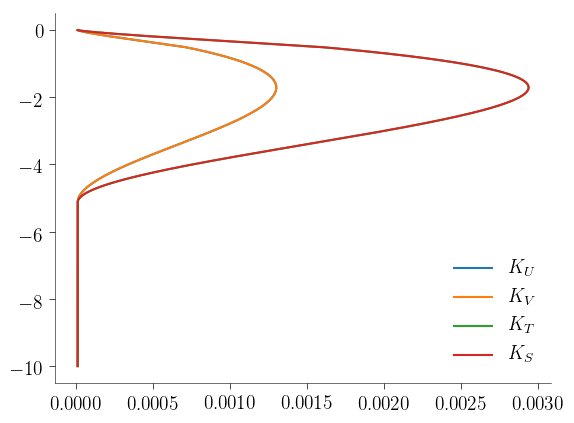

1.0e-5
1.0e-5
1.0e-5
1.0e-5


PyObject <matplotlib.legend.Legend object at 0x140ee2b00>

In [71]:
fig, axs = subplots()
cornerspines()

for u in (:U, :V, :T, :S)
    us = "$u"
    Ku = "\$ K_$us \$"
    K = Symbol(:K, u)
    ex = quote
        plot($K, label=$Ku)
        println($K[model.grid.N+1])
    end
    
    eval(ex)
    
end

legend()